In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import numpy.random as npr
from numba import jit,  njit, float64

from math import pi, cos, sin
tau = 2*pi

In [7]:
@njit
def random_disjoint_intervals(bounds):
    lens = collapse_intervals(bounds)
    total_len=lens[-1]
    
    R=npr.rand()*total_len
    
    idx=0
    for i in range(len(bounds)):
        if R <= lens[i]:
            idx = i
            break
    lb = bounds[idx][0]
    ub = bounds[idx][1]
    R_star = (ub-lb)*npr.rand()+lb
    return R_star

@njit
def collapse_intervals(bounds):
    lens=[]
    for i in range(len(bounds)):
        lb=bounds[i][0]
        ub=bounds[i][1]
        lens.append(ub-lb)
    lens=np.array(lens)
    return lens.cumsum()

def check_bound(v,bound):
    '''
    checks a single value against its bounds, and returns 
    the closest bound if it's in violation 
    '''
    for b in bound:
        if v>=b[0] and v<=b[1]:
            return v
    return min([(abs(x-v),x) for x in bound.flatten()])[1]

def ensure_bounds(psi, bounds):
    new_psi=[]
    for v, bound in zip(psi,bounds):
        new_psi.append(check_bound(v,bound))
    return new_psi

for i in range(10):
    print(check_bound(i,np.array([[1,1.5],[7.5,9]])))

bounds = {'pos':np.array([[0,0*tau]]),'ang':np.array([[0,1*tau/16],[tau/2-tau/16,tau/2]]),'burn':np.array([[3.2,3.9]])}
print(ensure_bounds([-1,100,4],bounds.values()))

1.0
1
1.5
1.5
1.5
7.5
7.5
7.5
8
9
[0.0, 3.141592653589793, 3.9]


In [8]:
%timeit random_disjoint_intervals(np.array([[0.,3.],[3.5,10.]]))
%timeit check_bound(10,np.array([[1,1.5],[7.5,9]]))
%timeit ensure_bounds([-1,100,4],bounds.values())

The slowest run took 15.40 times longer than the fastest. This could mean that an intermediate result is being cached.
9.9 µs ± 14.9 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
12.5 µs ± 948 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
24.2 µs ± 1.13 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


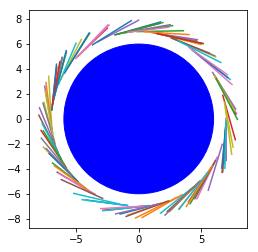

In [9]:
N=10000
bounds={'pos':np.array([[0,1*tau]]),'ang':np.array([[0,0],[tau/2,tau/2]]),'burn':np.array([[3.2,3.9]])}
pts=[]
for i in range(N):
    newpt=[]
    for b in bounds.values():
        newpt.append(random_disjoint_intervals(b))
    pts.append(newpt)
    
# for i,x in enumerate(np.array(pts).T):
#     plt.hist(x,bins=100)
#     plt.show()
    
ax=plt.gca()
earth=plt.Circle((0,0),6,color='blue')
ax.set_aspect('equal')
for psi in pts[::100]:
    pos,ang,burn=psi
    
    vhat_x,vhat_y=sin(pos),-cos(pos)
    x0,y0 = 7*cos(pos),7*sin(pos)
    burnvx=cos(ang)*vhat_x - sin(ang) * vhat_y
    burnvy=sin(ang)*vhat_x + cos(ang) * vhat_y
    
    
    ax.plot([x0,burn*burnvx+x0],[y0,burn*burnvy+y0])
ax.scatter(0,0) # make sure earth is on screen
ax.add_artist(earth)
plt.show()

In [59]:
bounds.values()

dict_values([array([[0., 0.]]), array([[0.        , 0.39269908],
       [2.74889357, 3.14159265]]), array([[3.2, 3.9]])])

In [60]:
for b in enumerate(bounds.values()):
    print(b)

(0, array([[0., 0.]]))
(1, array([[0.        , 0.39269908],
       [2.74889357, 3.14159265]]))
(2, array([[3.2, 3.9]]))


# Matrix Transformations
## ES algo GPU version

In [127]:
import numpy as np
from scipy.stats import rankdata

In [128]:
indi, jit = 5, 3
sigma,alpha=0.3,0.03
indivs=[[1,1,1],[10,10,10],[100,100,100],[1000,1000,1000],[10000,10000,10000]]
bounds = {'pos':np.array([[0,0*tau]]),'ang':np.array([[0,1*tau/16],[tau/2-tau/16,tau/2]]),'burn':np.array([[3.2,3.9]])}

jitter=np.random.rand(indi,jit,3)
jitter=np.array([sigma*jitt for jitt in jitter])
jitter=jitter.reshape(jit,indi,3)
jitter[0]*=0
points=indivs+jitter
points=points.reshape(jit*indi,3)
points=np.array([p * 2 for p in points]) # TODO replace with ensure_bounds eval
points=points.reshape(jit,indi,3)
successes=np.zeros(indi*jit,dtype=bool)
scores=np.zeros(indi*jit)

## Simulations are run here

In [135]:
successes=successes.reshape(indi*jit)
successes[int(indi*jit/2):]=True
print(successes)
scores = np.arange(indi*jit,dtype=float)
points=points.reshape(jit*indi,3)
for i,_ in enumerate(scores):
    scores[i] += points[i][2]
    if not successes[i]:
        scores[i] += 10
        scores[i] *= 10
print(points)

successes = successes.reshape(indi,jit)
scores = scores.reshape(indi,jit)
print (successes,'\n',scores,'\n\n')
scores = np.array([rankdata(sig_eps,method='ordinal') for sig_eps in scores])
scores = -scores
print(scores)



[False False False False False False False  True  True  True  True  True
  True  True  True]
[[2.00000000e+00 2.00000000e+00 2.00000000e+00]
 [2.00000000e+01 2.00000000e+01 2.00000000e+01]
 [2.00000000e+02 2.00000000e+02 2.00000000e+02]
 [2.00000000e+03 2.00000000e+03 2.00000000e+03]
 [2.00000000e+04 2.00000000e+04 2.00000000e+04]
 [2.38530664e+00 2.07825770e+00 2.55803812e+00]
 [2.00294767e+01 2.05739621e+01 2.03687944e+01]
 [2.00577622e+02 2.00042715e+02 2.00396840e+02]
 [2.00058343e+03 2.00046172e+03 2.00053552e+03]
 [2.00001861e+04 2.00001545e+04 2.00000704e+04]
 [2.55284930e+00 2.12524417e+00 2.00423576e+00]
 [2.05250492e+01 2.04375915e+01 2.02926749e+01]
 [2.00479415e+02 2.00322400e+02 2.00198914e+02]
 [2.00049211e+03 2.00047139e+03 2.00042011e+03]
 [2.00001024e+04 2.00000204e+04 2.00000690e+04]]
[[False False False]
 [False False False]
 [False  True  True]
 [ True  True  True]
 [ True  True  True]] 
 [[1.20000000e+02 3.10000000e+02 2.12000000e+03]
 [2.01300000e+04 2.00140000e+0

In [130]:
steps=np.zeros([indi,3])
jitterT=jitter.transpose(1,0,2)
print(jitterT,jitterT.shape)
steps=np.array([np.dot(scores[idx],jitterT[idx]) * alpha for idx in range(len(steps))])
print(indivs)
indivs+=steps
print(indivs)

[[[0.         0.         0.        ]
  [0.19265332 0.03912885 0.27901906]
  [0.27642465 0.06262209 0.00211788]]

 [[0.         0.         0.        ]
  [0.01473835 0.28698103 0.18439719]
  [0.26252462 0.21879574 0.14633746]]

 [[0.         0.         0.        ]
  [0.28881102 0.0213575  0.19841977]
  [0.23970726 0.16120009 0.09945678]]

 [[0.         0.         0.        ]
  [0.29171339 0.23086031 0.26776014]
  [0.24605549 0.23569405 0.21005397]]

 [[0.         0.         0.        ]
  [0.09303061 0.07723386 0.03518699]
  [0.05118161 0.01021382 0.03450805]]] (5, 3, 3)
[[1, 1, 1], [10, 10, 10], [100, 100, 100], [1000, 1000, 1000], [10000, 10000, 10000]]
[[9.63562582e-01 9.92016281e-01 9.83068247e-01]
 [9.99079781e+00 9.96760784e+00 9.97901413e+00]
 [9.99697620e+01 9.99848513e+01 9.99850963e+01]
 [9.99976485e+02 9.99978933e+02 9.99979364e+02]
 [9.99998981e+03 9.99999445e+03 9.99999478e+03]]


In [148]:
myvars=['indi','jit','indivs','jitter','points','successes','scores','steps','jitterT']
for name in myvars:
    shape=''
    if eval(name) is np.array:
        shape=eval(name).shape
    print(f"{name}\n  {eval(name)}, {shape}\n")

indi
  5, 

jit
  3, 

indivs
  [[9.63562582e-01 9.92016281e-01 9.83068247e-01]
 [9.99079781e+00 9.96760784e+00 9.97901413e+00]
 [9.99697620e+01 9.99848513e+01 9.99850963e+01]
 [9.99976485e+02 9.99978933e+02 9.99979364e+02]
 [9.99998981e+03 9.99999445e+03 9.99999478e+03]], 

jitter
  [[[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.19265332 0.03912885 0.27901906]
  [0.01473835 0.28698103 0.18439719]
  [0.28881102 0.0213575  0.19841977]
  [0.29171339 0.23086031 0.26776014]
  [0.09303061 0.07723386 0.03518699]]

 [[0.27642465 0.06262209 0.00211788]
  [0.26252462 0.21879574 0.14633746]
  [0.23970726 0.16120009 0.09945678]
  [0.24605549 0.23569405 0.21005397]
  [0.05118161 0.01021382 0.03450805]]], 

points
  [[[2.00000000e+00 2.00000000e+00 2.00000000e+00]
  [2.00000000e+01 2.00000000e+01 2.00000000e+01]
  [2.00000000e+02 2.00000000e+02 2.00000000e

In [145]:
winners=[]
intermediate_winners=[]
successes = successes.reshape(indi,jit)
points=points.reshape(indi,jit,3)
for idx, psi in enumerate(psis):
            if successes[idx][0]:
                winners.append(str([idx, psi, scores[idx][0]]) + "\n")
            for jdx, succ in enumerate(successes[idx][1:]): # all but the first value, since the first value is the individual itself
                if succ:
                    intermediate_winners.append(
                        " -- " + str([[idx,jdx+1], points[idx][jdx+1], scores[idx][jdx+1]]) + "\n"
                    )

In [146]:
winners

['[3, [0.0, 0.08178609464105333, 3.3313907925070874], -3]\n',
 '[4, [0.0, 2.756994081469272, 3.482816983510114], -1]\n']

In [147]:
intermediate_winners

[' -- [[2, 1], array([200.57762203, 200.042715  , 200.39683954]), -1]\n',
 ' -- [[2, 2], array([2000.58342678, 2000.46172061, 2000.53552027]), -3]\n',
 ' -- [[3, 1], array([2.5528493 , 2.12524417, 2.00423576]), -1]\n',
 ' -- [[3, 2], array([20.52504924, 20.43759148, 20.29267492]), -2]\n',
 ' -- [[4, 1], array([2000.49211099, 2000.47138809, 2000.42010794]), -2]\n',
 ' -- [[4, 2], array([20000.10236323, 20000.02042764, 20000.06901609]), -3]\n']

In [150]:
tau - 2.277654673852600

4.005530633326986